# OLS

In [344]:
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
font = {'family' : 'Helvetica',
        'size'   : 10}

matplotlib.rc('font', **font)
%matplotlib inline


In [332]:
constraint = pl.read_csv('constraints_matrix.csv').drop("")
constraint

Intercept,factor1,factor2,factor3,factor4,factor5,country_AU,country_BE,country_CA,country_CH,country_CN,country_DE,country_DK,country_ES,country_FI,country_FR,country_GB,country_HK,country_IE,country_IT,country_JP,country_NL,country_NO,country_SE,country_US,sector_50,sector_51,sector_52,sector_53,sector_54,sector_55,sector_56,sector_57,sector_59,sector_60
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.035591,0.053997,0.101596,0.13687,0.100007,0.124168,0.112964,0.272961,0.031039,0.029471
0.0,0.0,0.0,0.0,0.0,0.0,0.023034,0.004401,0.029416,0.029896,0.040043,0.05171,0.008762,0.009359,0.004424,0.037693,0.04913,0.010141,0.006178,0.007631,0.087637,0.023934,0.003243,0.012298,0.553611,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [333]:
market_data = pl.read_csv('data.csv')
market_data.head(5)

,wgt,total_return_1d,factor1,factor2,factor3,factor4,factor5,Intercept,country_AU,country_BE,country_CA,country_CH,country_CN,country_DE,country_DK,country_ES,country_FI,country_FR,country_GB,country_HK,country_IE,country_IT,country_JP,country_NL,country_NO,country_SE,country_US,sector_50,sector_51,sector_52,sector_53,sector_54,sector_55,sector_56,sector_57,sector_59,sector_60
i64,f64,f64,f64,f64,f64,f64,f64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
0,0.024601,0.003722,-1.050672,1.711051,-1.028368,-3.0,0.521842,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0
1,0.003095,0.011205,-0.923502,0.367834,0.538972,-2.425261,0.201721,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
2,0.000218,-0.02293,0.499339,-0.176547,0.688917,2.371205,-1.916686,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
3,0.000192,0.016528,-1.000445,0.807711,-0.214987,2.566137,1.458035,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
4,0.001642,0.003513,1.01401,-0.929822,0.676693,-0.813138,0.652653,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0


In [334]:
market_data.sum()

,wgt,total_return_1d,factor1,factor2,factor3,factor4,factor5,Intercept,country_AU,country_BE,country_CA,country_CH,country_CN,country_DE,country_DK,country_ES,country_FI,country_FR,country_GB,country_HK,country_IE,country_IT,country_JP,country_NL,country_NO,country_SE,country_US,sector_50,sector_51,sector_52,sector_53,sector_54,sector_55,sector_56,sector_57,sector_59,sector_60
i64,f64,f64,f64,f64,f64,f64,f64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
4828278,0.999005,6.038911,1033.281753,-1178.725887,-606.338738,7469.807214,-1432.758762,3108,181,15,208,58,28,98,23,32,17,79,154,22,14,27,496,39,17,57,1484,146,304,488,469,242,434,278,391,111,237


In [335]:
def zscore_weighted(x, wgt, UpperBoundWinsorized, LowerBoundWinsorized):
    # Returns z-scored values
    x[x == 0] = np.nan  # Exposure kept to zero.
    x_mean = np.average(x, weights=wgt)  # Weighted mean
    x_sd = np.nanstd(x)  # Standard deviation ignoring NaN values
    x_z = (x - x_mean) / x_sd  # Z-score
    x_z = np.minimum(x_z, UpperBoundWinsorized)
    x_z = np.maximum(x_z, LowerBoundWinsorized)
    x_z[np.isnan(x_z.to_numpy())] = 0
    return x_z

In [336]:
contains = lambda x,y : [z for z in x if y in z]
countries = contains(market_data.columns, 'country')
sectors = contains(market_data.columns, 'sector')
styles = contains(market_data.columns, 'factor')
styles

['factor1', 'factor2', 'factor3', 'factor4', 'factor5']

In [337]:
for style in styles:
    print(style)
    zscores_values = market_data[style]
    zscores_new_values = market_data[style]
    zscores_sum =  0
    
    x_mean = abs(np.average(zscores_values, weights=market_data['wgt']))
    x_sd = abs(np.nanstd(zscores_values)-1) 
    print(x_mean)
    
    # ITERATE ZSCORE CALCULATION UNTIL THE ZSCORE DISTRIBUTION HAS A WEIGHTED MEAN OF 0 AND A STDEV OF 1
    while (x_mean > 0.0001 or x_sd > 0.0001) and zscores_sum != x_mean:
        zscores_sum = x_mean
        zscores_new_values = zscore_weighted(zscores_values, market_data['wgt'], 3, -3)

        if ( abs(np.average(zscores_new_values, weights=market_data['wgt'])) < x_mean ):
            zscores_values = zscores_new_values

        x_mean = abs(np.average(zscores_values, weights=market_data['wgt']))
        x_sd = abs(np.nanstd(zscores_values)-1) 
        print(x_mean)

    #print(zscores_values)
    market_data = market_data.with_columns(style, zscores_values.alias("tmp")).drop(style).rename({"tmp": style})

market_data.head(4)

factor1
4.355243850981491e-05
1.4478997844810243e-05
factor2
2.3785944518841984e-05
factor3
3.657705403304227e-05
6.489889248635825e-06
1.158043935246234e-06
factor4
0.0005825541677067644
0.00028366793840236615
0.00013806515190129082
6.719332043461194e-05
factor5
5.647476780624956e-05
9.164458145671788e-06


,wgt,total_return_1d,Intercept,country_AU,country_BE,country_CA,country_CH,country_CN,country_DE,country_DK,country_ES,country_FI,country_FR,country_GB,country_HK,country_IE,country_IT,country_JP,country_NL,country_NO,country_SE,country_US,sector_50,sector_51,sector_52,sector_53,sector_54,sector_55,sector_56,sector_57,sector_59,sector_60,factor1,factor2,factor3,factor4,factor5
i64,f64,f64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,f64,f64,f64,f64,f64
0,0.024601,0.003722,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,-1.050835,1.711051,-1.029519,-3.0,0.522003
1,0.003095,0.011205,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,-0.92364,0.367834,0.539509,-2.426875,0.201818
2,0.000218,-0.02293,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0.499481,-0.176547,0.689616,2.370797,-1.917015
3,0.000192,0.016528,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,-1.000598,0.807711,-0.215262,2.565777,1.458384


/Users/espenfolke/miniconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/espenfolke/miniconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


<Axes: >

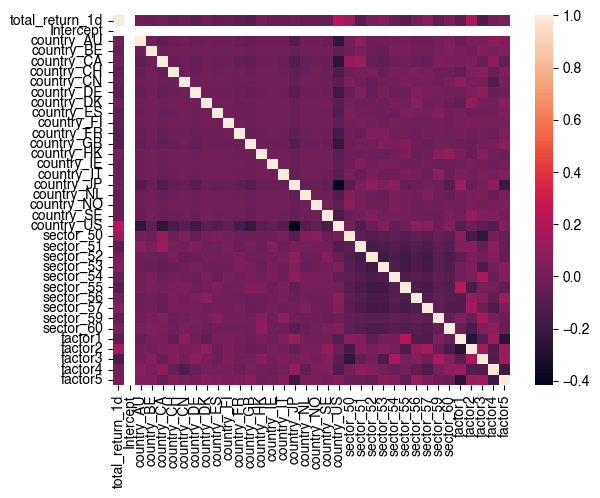

In [345]:
corr = market_data.drop(['','wgt']).corr()

# plot the heatmap
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

In [346]:
MW = market_data['wgt'].to_numpy().reshape(len(market_data), 1) * 1e5
R = market_data['total_return_1d'].to_numpy().reshape(len(market_data), 1)

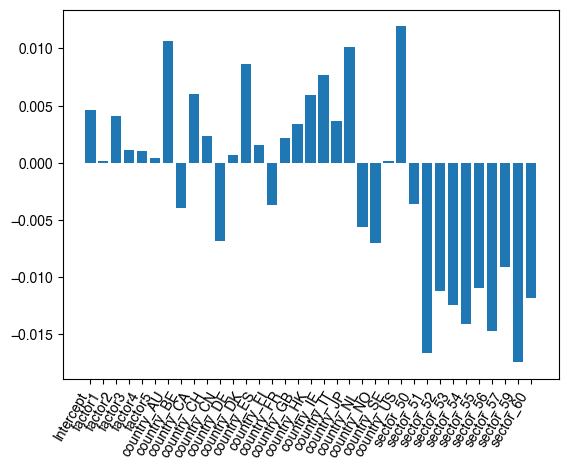

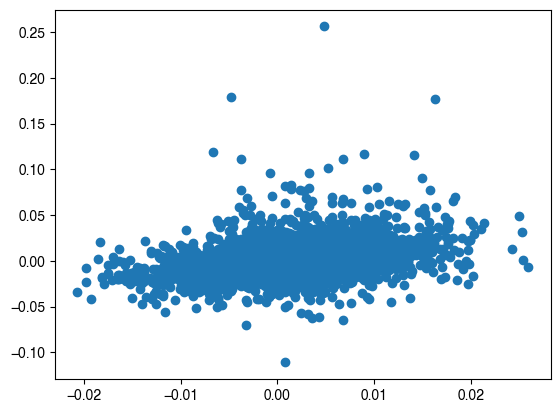

In [347]:
D =  market_data[constraint.columns]
bTwb = np.matmul(D.transpose(), MW*D)
bTwR = np.matmul(D.transpose(), MW*R)
# F = np.linalg.lstsq(bTwb, bTwR)[0]
F = np.linalg.pinv(bTwb) @ bTwR
# F = np.linalg.lstsq(MW*D, MW*R)[0]

# F = np.linalg.pinv(MW*D) @ (MW*R)

plt.bar(constraint.columns, F.reshape(len(F)),width=0.8)
plt.xticks(rotation=60, ha='right')
plt.show()


modelR = np.matmul(D, F)

plt.scatter(modelR,R)
plt.show()

# CLS 
## INCORRECT need to adjust this

In [348]:
MW = market_data[['wgt']] * 1e5
MW = MW.extend(pl.DataFrame({'wgt': [100.0,100.0]})).to_numpy().reshape(len(MW), 1)
# MW = MW.round()

R = market_data[['total_return_1d']]
R = R.extend(pl.DataFrame({'total_return_1d': [0.0,0.0]})).to_numpy().reshape(len(R), 1)

In [349]:
D =  market_data[constraint.columns]
D = D.with_columns(
   pl.col(constraint.columns).cast(pl.Float64, strict=False)
)
D = D.extend(constraint)

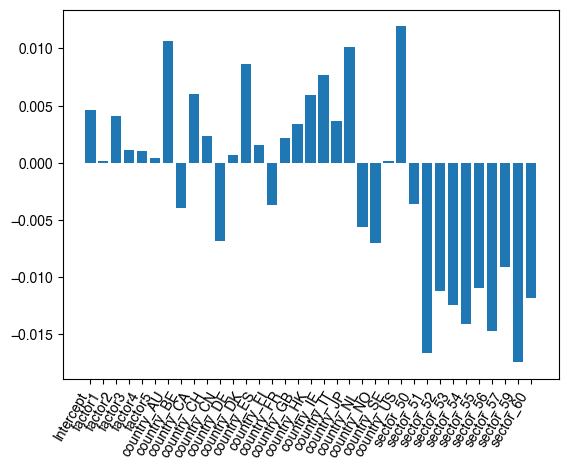

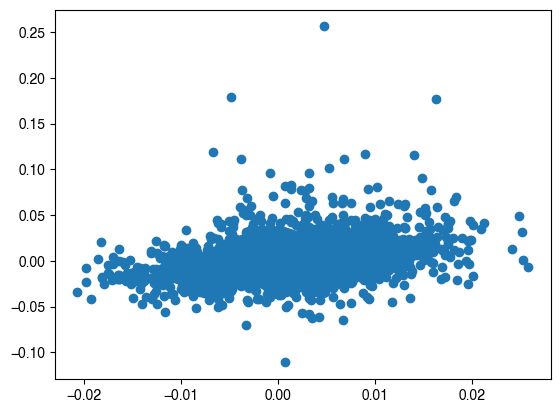

SeriesView([[ 7.57085856e-03],
            [ 1.73651003e-06],
            [ 5.11809774e-06],
            [-9.45286430e-07],
            [ 2.94566099e-06],
            [ 1.73529360e-06],
            [ 1.05944945e-03],
            [ 1.09157866e-03],
            [ 1.05815557e-03],
            [ 1.09999944e-03],
            [ 1.09706418e-03],
            [ 1.09547306e-03],
            [ 1.08736003e-03],
            [ 1.08741504e-03],
            [ 1.08224621e-03],
            [ 1.09726541e-03],
            [ 1.09007053e-03],
            [ 1.09235554e-03],
            [ 1.09764914e-03],
            [ 1.08400187e-03],
            [ 1.09356214e-03],
            [ 1.09387208e-03],
            [ 1.08279231e-03],
            [ 1.09027037e-03],
            [ 1.10050474e-03],
            [-8.63561929e-03],
            [-8.64125148e-03],
            [-8.66907642e-03],
            [-8.66906310e-03],
            [-8.66060479e-03],
            [-8.65435646e-03],
            [-8.66909147e-03],
        

In [350]:
bTwb = np.matmul(D.transpose(), MW*D)
bTwR = np.matmul(D.transpose(), MW*R)
# F = np.linalg.lstsq(bTwb, bTwR)[0]
# F = np.linalg.lstsq(MW*D, MW*R)[0]

F1 = np.linalg.pinv(bTwb) @ bTwR


plt.bar(constraint.columns, F.reshape(len(F)),width=0.8)
plt.xticks(rotation=60, ha='right')
plt.show()


modelR = np.matmul(D, F1)

plt.scatter(modelR,R)
plt.show()

F-F1

In [351]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
import seaborn as sns
import pandas

font = {'family' : 'Helvetica',
        'size'   : 10}

matplotlib.rc('font', **font)


np.random.seed(222)
DPPD = 200
X = np.random.normal(0,2, (DPPD, 2))


# target w
w_target = np.random.normal(0,1, (2,1))
w_target

array([[-1.20945938],
       [ 1.23928263]])

In [352]:
# constraints (overdetermined for multiple solutions)
d = np.random.normal(0,1, (1,1))
C = np.random.normal(0,1, (1,2))

# objective
y = X@w_target + np.random.normal(0, 0.2, (DPPD,1))

Y_tilde = [y, d]
X_tilde = [X, C]

# objective weights
lambd = np.asarray([1.0, 10000.0])


A_tilde = np.bmat([[np.sqrt(l)*x] for l,x in zip(lambd, X_tilde)])
y_tilde = np.bmat([[np.sqrt(l)*y] for l,y in zip(lambd, Y_tilde)])

# least squares
w_estimate = np.linalg.inv(A_tilde.T@A_tilde)@A_tilde.T@y_tilde


y_estimate = X@w_estimate

In [353]:
y_tilde.shape

(201, 1)

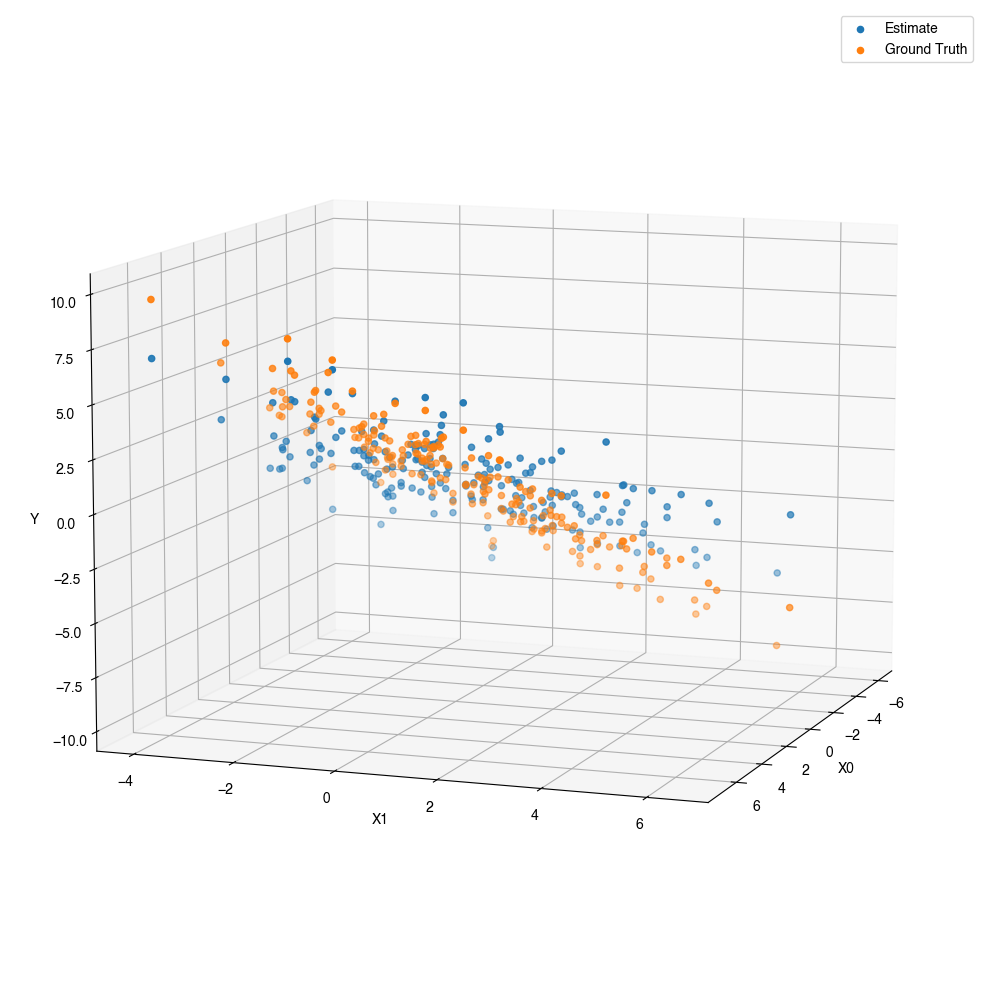

In [354]:
# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

import matplotlib.pyplot as plt
import numpy as np

x1 = y_estimate.flatten()
x2 = X[:, 0].flatten()
y_estimate = y_estimate.flatten()
y_true = y.flatten()

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x1,x2,y_estimate, label="Estimate")
ax.scatter(x1,x2,y_true, label="Ground Truth")
ax.view_init(elev=10., azim=20)

ax.set_xlabel('X0')
ax.set_ylabel('X1')
ax.set_zlabel('Y')

plt.legend()
plt.tight_layout()
# plt.savefig("3d.png")
plt.show()
